<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentation_1_class_cell_indiv_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentation one class (cell)

##Mount Google Drive, install load packages

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True);

MessageError: ignored

In [ ]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

In [ ]:
try:
  from google.cloud import storage
  client = storage.Client();
except Exception as e:
  print(e)
  print("error: no credentials, ignoring");

OSError: ignored

### Installing and loading packages 

In [ ]:
#!nvidia-smi

In [ ]:
import pandas as pd
#pip install --upgrade pandas

In [ ]:
pd.__version__

'1.3.5'

In [ ]:
pip install torch==1.7.1 torchvision==0.8.2

     |████████████████████████████████| 776.8 MB 17 kB/s 
     |████████████████████████████████| 12.8 MB 43.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
import torch
import torchvision
print(torch.__version__)


1.7.1


In [ ]:
print(torch.version.cuda)

10.2


In [ ]:
torch.cuda.is_available()

False

In [ ]:
#torch.cuda.get_device_name(0)

In [ ]:
#!pip install -q torch==1.7.0 torchvision

In [ ]:
#!pip install fastai==2.0.13 --no-deps


In [ ]:
#!pip install fastcore==1.0.13
!pip install fastcore

     |████████████████████████████████| 55 kB 2.5 MB/s 


In [ ]:
import fastcore


In [ ]:
#!pip install -Uqq fastbook

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 189 kB 13.5 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import fastai
fastai.__version__

'2.5.3'

In [ ]:
#import fastbook
#fastbook.setup_book()

In [ ]:
print(fastcore.__version__)


1.3.29


In [ ]:
from fastai.vision.all import *

In [ ]:
import imageio
from skimage.io import imread, imsave, imshow
from skimage.exposure import rescale_intensity
import os
import numpy as np
from pathlib import Path
import re
import ntpath

!ls

sample_data


# Segmentation Parameters


##Basic Parameters
other shared settings between training and separation

In [ ]:
#@markdown What object type you are segmenting (does nothing at this point)
segmentation_target = "Nucleus" #@param ["Nucleus", "Cell", "Combined"]

#@markdown local folder is "content" when working in colab, may be different for GCP AI
local_folder='content' #@param {type:"string"}
local_folder=Path(local_folder);

#@markdown place where all images and masks to be transferred to and from the GCP will be stored
GCP_transfer_folder = "gcp_transfer" #@param {type:"string"}
GCP_transfer_folder = Path(GCP_transfer_folder);
if not os.path.exists(GCP_transfer_folder):
  os.makedirs(GCP_transfer_folder);

gsutil_dest_folder = local_folder/GCP_transfer_folder;

#@markdown regex used to decipher filenames (Leave the same for metamorph outputs)
filename_regex = "p[0-9]*_s([0-9]+)_t([0-9]+).*\\.(tif|tiff|TIF|TIFF)" #@param{type:"string"}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: gcp_transfer/test.jpg is a low contrast image
  


##Cloud Storage Parameters
Filenames and parameters for using google cloud storage

In [ ]:
#@markdown The name of the bucket to use (exclude the gs://)
bucket = "optotaxisbucket" #@param {type:"string"}

#@markdown the name of the high level directory in the bucket where movie segmentation files wil be uploaded
GCP_parent_dir = "movie_segmentation" #@param {type:"string"}
GCP_parent_dir = Path(bucket)/GCP_parent_dir
#NOTE: whenever gsutil is used with GCP_parent_dir, you must add gs://{directory}

#@markdown the name of the folder in the parent directory where models are stored and will be exported to after training
modelsfolder = 'models' #@param {type:"string"}
gcp_modelsfolder = GCP_parent_dir/modelsfolder;
local_modelsfolder = GCP_transfer_folder/modelsfolder
del modelsfolder; #for testing purposes to make sure no old code is using this

## Image Preparation
shared settings between training and segmentation image/mask processing

In [ ]:
#@markdown Number of slices (columns/rows) to divide input images into; for the math, pleast check https://www.desmos.com/calculator/t3cyflvlef
x_slices = 5 #@param {type:"integer"}
y_slices =  5 #@param {type:"integer"}
#@markdown dx, dy are the extra context around the segmented center in both directions
dx =  42#@param {type:"integer"}
dy =  32#@param {type:"integer"}
#@markdown x and y crop are how much to straight remove from the image to make the sizes able to be subdivided nicely
x_crop = 0 #@param {type:"integer"}
y_crop = 0 #@param {type:"integer"}

context_bounds = [dy,dx]*2 #assuming x and y symmetrical, not always true -- fix?
crop = [y_crop,x_crop]*2 #both of these are negative y, negative x, positive y, positive x

## Training-Specific Settings
parameters and paths only for training

In [ ]:
#@markdown folder name where input images are stored in the GCP parent directory
training_images="training_images" #@param {type:"string"}
gcp_training_images=GCP_parent_dir/training_images;
local_training_images = GCP_transfer_folder/training_images;
del training_images; #for testing purposes to make sure no old code is using this

#@markdown folder name where input masks are stored in the GCP parent directory
training_masks="/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/training_masks" #@param {type:"string"}
gcp_training_masks=GCP_parent_dir/training_masks
local_training_masks = GCP_transfer_folder/training_masks;
del training_masks; #for testing purposes to make sure no old code is using this

#@markdown base model that will be used to train from
inmodelname = 'seg_nuc_062719_s_1_2_110619_bleb.pkl' #@param {type:"string"}
#@markdown where the model will be exported to after training
outmodelname = 'iter3_2_nuc_scratch_test.pkl' #@param {type:"string"}



## Segmentation-Specific Settings:
parameters and paths only for segmenting an experiment


In [ ]:
#@markdown folder name where input images are stored in the GCP bucket parent directory
segmentation_images="segmentation_images"  #@param {type:"string"}
gcp_segmentation_images=GCP_parent_dir/segmentation_images;
local_segmentation_images = GCP_transfer_folder/segmentation_images;
del segmentation_images; #for testing purposes to make sure no old code is using this

#@markdown folder name where output masks will be deposited in the GCP bucket parent directory
segmentation_output_masks='segmentation_output_masks' #@param {type:"string"}
gcp_segmentation_output_masks=GCP_parent_dir/segmentation_output_masks;
local_segmentation_output_masks=GCP_transfer_folder/segmentation_output_masks;
del segmentation_output_masks; #for testing purposes to make sure no old code is using this

#@markdown Whether to specify a specific model name for easy model switching. If no model name is specified, the program will look for a model with a name corresponding to the type of the images being segmented (in basic settings)
use_specified_model = True #@param {type:"boolean"}
specified_name="iter3_2_nuc_scratch_test.pkl" #@param {type:"string"}

segmentation_model_name = specified_name
if not use_specified_model:
  segmentation_model_name = GCP_parent_dir / (segmentation_target + ".pkl");
if "client" in locals():
  bs = client.list_blobs(bucket,prefix=segmentation_model_name)
  if bs is None or not next(bs):
    raise FileNotFoundError(f"Model {segmentation_model_name} does not exist");




# Preparing data to train only on cell (from combined nuc-memb masks)

###Prepare fast.ai data loader

In [ ]:
path=local_folder

In [ ]:
path2 = untar_data(URLs.CAMVID_TINY)

In [ ]:
def label_func(x): return training_masks/f'{x.stem}.TIF'

In [ ]:
codes = np.loadtxt(path2/'codes.txt', dtype=str)

In [ ]:
trainingset = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   #batch_tfms=aug_transforms(size=(512,672)))
                   batch_tfms=aug_transforms(size=(256,336)))

In [ ]:
dls = trainingset.dataloaders(training_images, path=path, bs=8);
print(os.listdir(training_images));
# dls.dataset
# dls.n_inp

['random_s7_t99-3.TIF', 'random_s2_t187-13.TIF', 'random2_s2_t14-24.TIF', 'random_s10_t126-21.TIF', 'random_s6_t179-19.TIF', 'random_s12_t82-12.TIF', 'random_s7_t5-22.TIF', 'migration4_s14_t253-3.TIF', 'migration4_s13_t262-7.TIF', 'migration4_s14_t253-24.TIF', 'random2_s7_t84-0.TIF', 'random_s9_t92-21.TIF', 'random_s7_t5-13.TIF', 'random2_s2_t179-14.TIF', 'random_s6_t179-9.TIF', 'random_s7_t99-2.TIF', 'random_s12_t82-1.TIF', 'random2_s1_t66-18.TIF', 'random_s6_t179-11.TIF', 'random2_s11_t23-20.TIF', 'migration4_s14_t253-6.TIF', 'random_s7_t5-5.TIF', 'random_s2_t187-19.TIF', 'migration4_s13_t262-1.TIF', 'migration1_s9_t16-24.TIF', 'random_s7_t5-6.TIF', 'random_s2_t187-11.TIF', 'random2_s11_t47-11.TIF', 'random_s10_t126-18.TIF', 'random_s12_t82-18.TIF', 'random2_s15_t47-2.TIF', 'random2_s2_t179-5.TIF', 'random_s8_t179-11.TIF', 'random_s12_t82-10.TIF', 'random_s9_t92-13.TIF', 'random_s7_t5-17.TIF', 'random_s10_t126-4.TIF', 'random_s13_t71-6.TIF', 'random_s16_t246-7.TIF', 'random2_s15_t47-

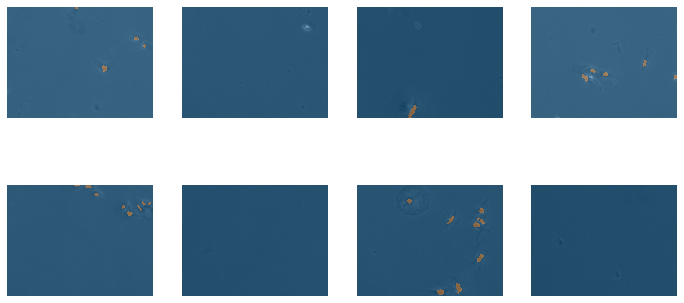

In [ ]:
dls.show_batch(max_n=10)

#Training

In [ ]:
#learn = unet_learner(dls, resnet34)
loadedlearner=load_learner(modelsfolder/inmodelname,cpu=True)
loadedlearner.dls=dls

In [ ]:
#learn.fine_tune(8)
loadedlearner.fine_tune(5)


epoch,train_loss,valid_loss,time
0,0.004593,0.004641,01:30


epoch,train_loss,valid_loss,time
0,0.004059,0.005130,01:33
1,0.004342,0.004213,01:33
2,0.004023,0.004078,01:33
3,0.003763,0.004170,01:33
4,0.003491,0.004134,01:33


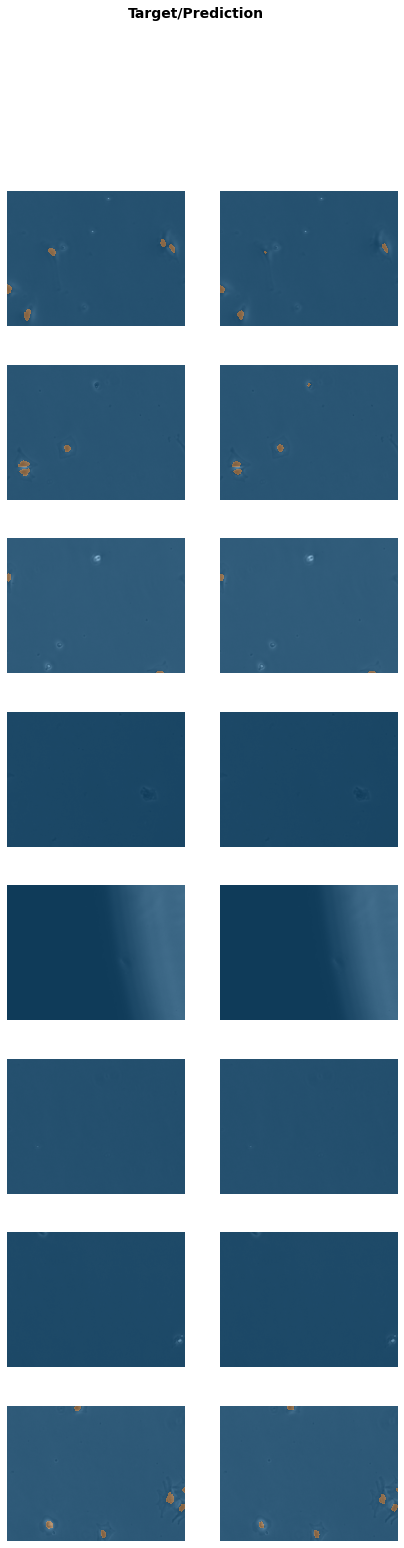

In [ ]:
n = 16
loadedlearner.show_results(max_n=n, figsize=(7,25))

In [ ]:
loadedlearner.export(fname=modelsfolder/outmodelname, pickle_protocol=2)

# Segment Experiment
Will process all images in the segmentation input folder and continuously output segmented masks into the segmentation output masks folder in GCP.

###Pull GCP folders to local environment

In [ ]:
#models folder
!gsutil -m cp -r gs://{gcp_modelsfolder} {gsutil_dest_folder}

#segmentation images
!gsutil -m cp -r gs://{gcp_segmentation_images} {gsutil_dest_folder}

### Loading a trained model

In [ ]:
print("available cpu count:",len(os.sched_getaffinity(0)));

available cpu count: 2


In [ ]:
def label_func(x): return None; ##dummy function to make unpickling work, never used
loadedlearner=load_learner(segmentation_model_name,cpu=True);
if torch.cuda.is_available():
  print("using gpu");
  loadedlearner.model = loadedlearner.model.cuda();


using gpu


### Do pre-segmentation file management
Create output folder, find which files are remaining to segment, chunk files into batches for segmentation and upload

In [ ]:
os.mkdir(local_segmentation_output_masks);
## prepare files

toplevel_images = True;

#as far as I can tell through testing, this only matters for ensuring RAM usage stays low
batchSize = 128; 

files = get_image_files(local_segmentation_images);

completed_masks = !gsutil ls {gcp_segmentation_output_masks}
completed_masks += os.listdir(local_segmentation_output_masks);
completed_masks = [os.path.basename(x) for x in completed_masks];

print("input files:",len(files))
print("output files:",len(completed_masks))

files = [fi for fi in files if os.path.basename(fi) not in completed_masks];
print("remaining files:",len(files))
total_files = len(files);

fileChunks = chunked(files, chunk_sz=batchSize);


pulling files from segmentation_images
input files: 400
output files: 0
remaining files: 400


In [ ]:
for chunk in master_bar(fileChunks,total_files//batchSize+1):
  # print('processing batch...');
  dl = loadedlearner.dls.test_dl(chunk,num_workers=len(os.sched_getaffinity(0)));
  if torch.cuda.is_available():
    dl = loadedlearner.dls.test_dl(chunk,num_workers=len(os.sched_getaffinity(0)),device='cuda');
    dl.to('cuda');
  _,_,dec_preds = loadedlearner.get_preds(with_decoded=True,dl=dl);
  for path,prediction in zip(chunk,dec_preds):
    basename = os.path.basename(path);
    # print("saving to",outFolder/basename);
    # print(prediction.shape);
    imsave(local_segmentation_output_masks/basename,prediction.numpy().astype('uint8'),check_contrast=False);
  !gsutil -m cp -r -n {local_segmentation_output_masks} gs://{GCP_parent_dir}
with open(local_segmentation_output_massks/'segmentation_complete.flag','w') as f:
  pass;
!gsutil -m cp -r -n {local_segmentation_output_masks} gs://{GCP_parent_dir}
print("folder processing complete");

segmentation_images segmentation_output_masks 400


folder processing complete
